# Denoising Diffusion Probabilistic Models

DDPMs "navigate" from Gaussian noise points to distribution points similarly to normalizing flows.
Big difference is how these models define the path:

- similarly to NFs they move in small steps;
- differently to NFs they try to iteratively remove some noise at each step.

Consider the process of adding noise (and aplying a normalization) to an input image:

![Denoising process](images/DDPM.png)

The forward (respectively backward, aka denoising) process can be seen as a markov chain:

![Denoising process](images/diffusion_model.png)

where every state $x_t$ is computed from the previous $x_{t-1}$ ($x_{t+1}$) state.

Ultimately, from a sample drawn from the image (noise) distribution 
can be transformed in a sample drawn from the noise (image) distribution.

The forward process seems to be straight-forward, but requires care in scheduling the amount of noise.

The backward process, that is the one that makes the model generative, 
seems to be somewhat "magical": it "allucinates" data in the pure noise.

Let's see how this works.

## Forward process: noise sheduling

Consider a process that aims to:

- schedule noise variances $\sigma_t^2=\beta_t$ for isotropic additive noise to be added;
- sample noise as $\eta_t\sim\mathcal{N}(\cdot; 0, \beta_t)$;
- consider a noise corruption step $x_{t-1} \to x_t = x_{t-1} + \eta_t$;
- for every corruption step a scale normalization is needed to reach a normal distribution;
- execute T (fixed) steps from $x_0$ to $x_T$.

Being the sum of normal distrubutions again normally distributed:

$$\large
\left.
\begin{array}{rr}
    x\sim\mathcal{N}(\cdot;\mu_X,\sigma_X^2) \\
    x\sim\mathcal{N}(\cdot;\mu_Y,\sigma_Y^2)
\end{array}
\right\}
\to x+y\sim\mathcal{N}(\cdot;\mu_X+\mu_Y,\sigma_X^2+\sigma_Y^2)
$$

we can express the sample $x_t$ directly wrt $x_0$ and a noise schedule parameter $\beta_t$:

$$\large
x_t \sim \mathcal{N}(\cdot;\sqrt{1-\beta_t}x_{t-1},\beta_t)
$$

defining $\alpha_t = 1-\beta_t$ and $\bar{\alpha}_t=\prod_1^t\alpha_t$, we have:

$$\large
x_t \sim \mathcal{N}(\cdot;\sqrt{\bar{\alpha}_t}x_0,1-\bar{\alpha}_t)
$$


In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


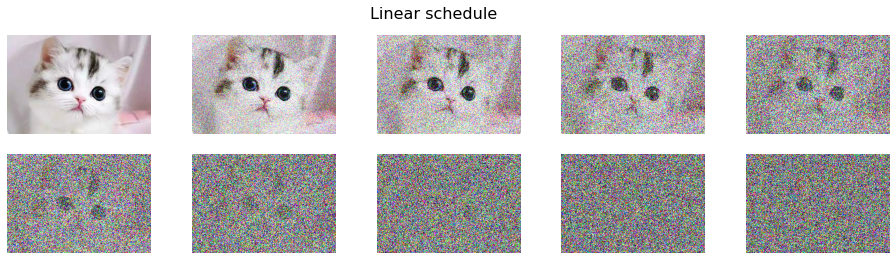

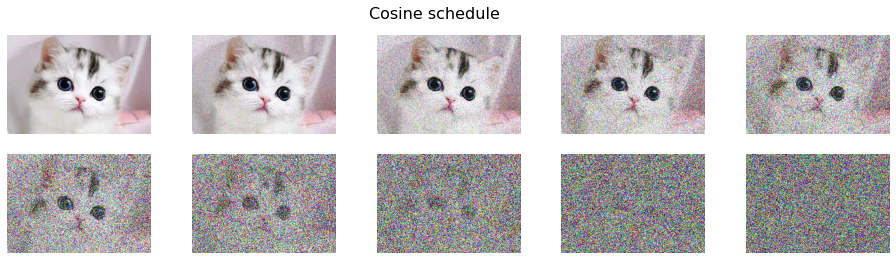

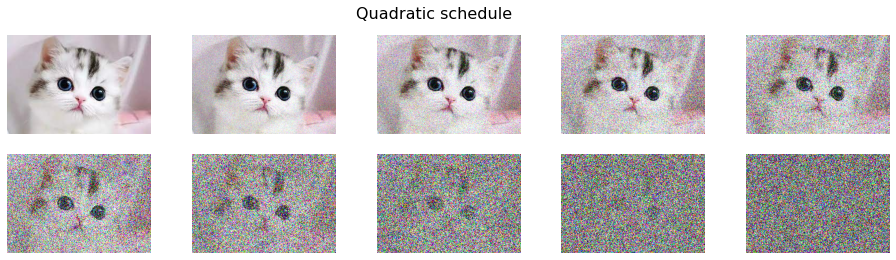

In [119]:
import numpy as np
import torch
from torchvision.io import read_image
from matplotlib import pyplot as plt
from ddpm import Corruptor, normalize_image, denormalize_image


def plot_images(images, title="", rows=1):
    figure, axis = plt.subplots(rows, len(images) // rows)
    figure.set_figwidth(16)
    figure.suptitle(title, fontsize=16)
    for t, x_t in enumerate(images):
        if rows > 1:
            x, y = t % len(axis[0]), t // len(axis[0])
            ax = axis[y][x]
        else:
            ax = axis[t]
        ax.grid(False)
        ax.axis('off')
        ax.imshow(x_t.permute(1,2,0))    


def plot_corruptions(img, schedule, title="", rows=1):
    img = normalize_image(img)
    corruptor = Corruptor(schedule)
    
    def prepare_image(t):
        x_t, _ = corruptor.corrupt(img,t)
        return denormalize_image(x_t)
    
    images = [
        prepare_image(t)
        for t in range(len(corruptor))
    ]
    
    plot_images(images,title,rows)

    
img = read_image("images/cat.jpg") / 255.
N = 10

linear = np.linspace(0.,1.,N)
plot_corruptions(img, linear, "Linear schedule", rows=2)
cosine = 1-np.cos(np.linspace(0.,np.pi/2,N))
plot_corruptions(img, cosine, "Cosine schedule", rows=2)
quadratic = np.linspace(0.,1.,N)**2
plot_corruptions(img, quadratic, "Quadratic schedule", rows=2)

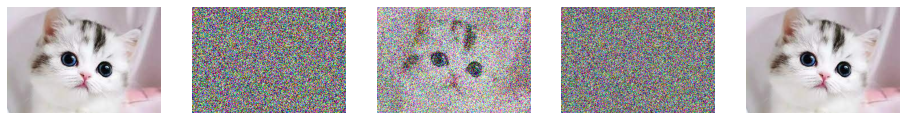

In [120]:
# Test: let's corrupt and uncorrupt an image:
corruptor = Corruptor(quadratic)
x_0, t = normalize_image(img), 5
x_t, eps_t = corruptor.corrupt(x_0, t)
eps_tr = corruptor.scale_noise(eps_t, t)
x_0r = corruptor.uncorrupt(x_t, eps_t, t)

# The sequence of images:
plot_images([denormalize_image(im) for im in (x_0, eps_t, x_t, eps_tr, x_0r)])

In [4]:
from dataset import load_mnist

# Using the MNIST dataset:
train_ds = load_mnist(train=True)[0]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



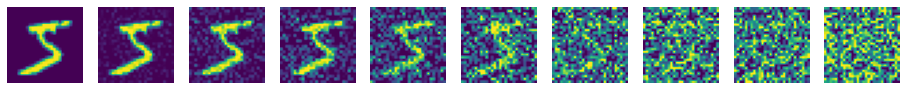

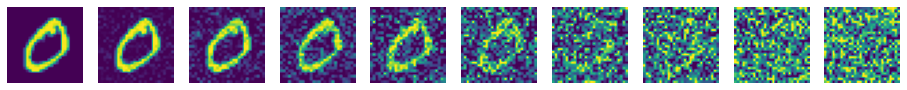

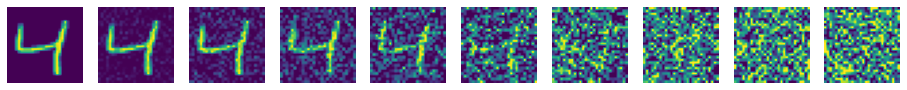

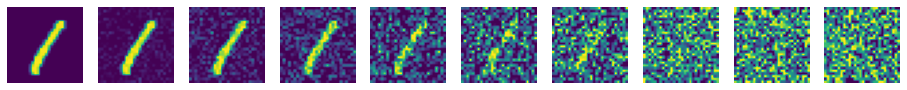

In [121]:
# Check some corruptions:
for i in range(4):
    plot_corruptions(train_ds[i:i+1,:,:], cosine)

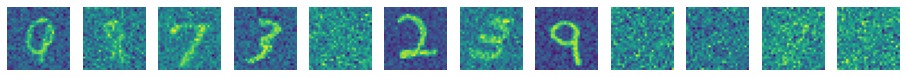

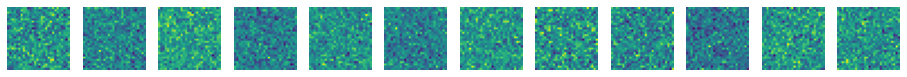

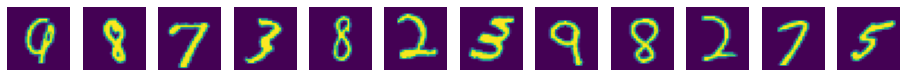

In [122]:
from torch.utils.data import DataLoader
from ddpm import DdpmDataset

# Using a ddpm dataset to introduce noise:
corruptor = Corruptor(quadratic[:-1]) # Cannot uncorrupt the last one.
dataset = DdpmDataset(train_ds, corruptor)
dl = DataLoader(dataset, batch_size=12, shuffle=True)

# Random sampling from a dataset and uncorrupting:
x_ts, epss, ts = next(iter(dl))
noise = [
    corruptor.scale_noise(eps, t) 
    for eps, t 
    in zip(epss.split(1), ts.split(1))
]
uncorrupted = [
    corruptor.uncorrupt(x_t, eps, t) 
    for x_t, eps, t 
    in zip(x_ts.split(1), epss.split(1), ts.split(1))
]
plot_images(x_ts.split(1))
plot_images(noise)
plot_images(uncorrupted)

## The probabilistic model

Both the noising and denoising processes are Markov chains:

$$
\Large p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1}|x_t) \\
\Large q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})
$$

For both the single Markov chain step is normally distributed:

$$
\Large p_\theta(x_{t-1}|x_t) = \mathcal{N}(\cdot|\mu_\theta(x_t,t),\Sigma_\theta(x_t,t)) \\
\Large q(x_t|x_{t-1}) = \mathcal{N}(\cdot|\sqrt{1-\beta_t}x_{t-1},\beta_t)
$$

## The optimization problem

Similarly to VAE, the variational bound can be optimized:

$$\Large
\begin{eqnarray}
\mathbb{E}\left[-\log p_\theta(x_0)\right] 
    &\leq& \mathbb{E}_q\left[-\log\frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}\right] \\
    &=& \mathbb{E}_q\left[-\log p(x_T) - \sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\right]
    = L
\end{eqnarray}
$$

Fixing $\Sigma_\theta(x_t,t) = \beta_t$, the loss associated to a single step can be written as:

$$\Large
L_{t-1} = \mathbb{E}\left[\left\|\mu_t(x_t|x_{t+1}) - \mu_\theta(x_t,t)\right\|^2\right]
$$

Instead of estimating $\mu_t$ directly, the noise $\epsilon_\theta(x_t,t)$ is estimated.

At sampling time, the update step consists in removing the right proportion of the estimated noise:

$$\Large
\mu_\theta(x_t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}}}\epsilon_\theta(x_t,t)\right)
$$

## Langevin dynamics

At sampling time, it is not possible to sample just applying the denoising step.

**The denoising step alone brings to mode collapse.**

Denoising must adopt noise to prevent mode collapse:

<img src="images/langevin.gif"/>

Given that, the update step is:

$$\Large
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}
    \left(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}}}\epsilon_\theta(x_t,t)\right) 
    + \sqrt{\beta_t}z
$$

where $z\sim\mathcal{N}(\cdot;0,1)$.

In [297]:
from ddpm import Unet, train

corruptor = Corruptor((np.linspace(0.,1.,1000)**2)[:-1])
model, losses = train(
    dataset=train_ds[:,None,:,:].cuda(),
    corruptor=corruptor,
    epochs=500,
)

  0%|          | 0/500 [00:00<?, ?it/s]

train_loss[1] = 0.8771555522230389

train_loss[2] = 0.1486162569707454

train_loss[3] = 0.06786044257313711

train_loss[4] = 0.050693070581520415

train_loss[5] = 0.04549151932451326

train_loss[6] = 0.04054913000622665

train_loss[7] = 0.037844713481425096

train_loss[8] = 0.03602002625431079

train_loss[9] = 0.03518487492314121

train_loss[10] = 0.03429811843819837

train_loss[11] = 0.03275517721884826

train_loss[12] = 0.03290125342316306

train_loss[13] = 0.032093197090436086

train_loss[14] = 0.031253442696448586

train_loss[15] = 0.030258852003543363

train_loss[16] = 0.030172072894084873

train_loss[17] = 0.030088307853263895

train_loss[18] = 0.029371983816485796

train_loss[19] = 0.028955796088125787

train_loss[20] = 0.02901298821127332

train_loss[21] = 0.028582387183830618

train_loss[22] = 0.028653905873915662

train_loss[23] = 0.027455418604984086

train_loss[24] = 0.027258875869166876

train_loss[25] = 0.0272324500806026

train_loss[26] = 0.026354987042219336

train_loss

train_loss[211] = 0.018471856669548637

train_loss[212] = 0.01875027715822241

train_loss[213] = 0.01895784153771807

train_loss[214] = 0.019003385123905977

train_loss[215] = 0.01901825789664028

train_loss[216] = 0.019199667547616973

train_loss[217] = 0.018973771902198382

train_loss[218] = 0.01924667382257373

train_loss[219] = 0.018797370924382037

train_loss[220] = 0.019250372799037935

train_loss[221] = 0.019083342500038937

train_loss[222] = 0.019059766994924274

train_loss[223] = 0.01892154706445441

train_loss[224] = 0.019058967847178487

train_loss[225] = 0.0187066180074512

train_loss[226] = 0.01926390018149305

train_loss[227] = 0.01884322775168412

train_loss[228] = 0.019210732627366143

train_loss[229] = 0.019081724656205664

train_loss[230] = 0.019228008428791056

train_loss[231] = 0.018861504370418152

train_loss[232] = 0.018979149233144737

train_loss[233] = 0.018860095291773776

train_loss[234] = 0.019366313081814537

train_loss[235] = 0.019409731887320657

train_los

train_loss[420] = 0.017822802640688317

train_loss[421] = 0.0178488771523486

train_loss[422] = 0.0179626676065327

train_loss[423] = 0.01770024332972462

train_loss[424] = 0.017541570583485495

train_loss[425] = 0.017593709774303443

train_loss[426] = 0.017936868210837467

train_loss[427] = 0.01765359715739293

train_loss[428] = 0.01787832217253268

train_loss[429] = 0.017634302754995664

train_loss[430] = 0.017637641287283665

train_loss[431] = 0.017899766903438134

train_loss[432] = 0.017687621438053688

train_loss[433] = 0.017896577038728732

train_loss[434] = 0.017733398508201086

train_loss[435] = 0.017467353030292593

train_loss[436] = 0.017678863232903706

train_loss[437] = 0.017611991021353236

train_loss[438] = 0.017994862176906833

train_loss[439] = 0.0180042252671331

train_loss[440] = 0.017722277324706284

train_loss[441] = 0.017587710702136508

train_loss[442] = 0.017819519670032806

train_loss[443] = 0.017905016234124712

train_loss[444] = 0.017580551958120645

train_los

In [298]:
from training import load_model
from ddpm import Unet

# Reloading the model:
model, losses = load_model('models/ddpm0500', Unet())
corruptor = Corruptor((np.linspace(0.,1.,1000)**2)[:-1])

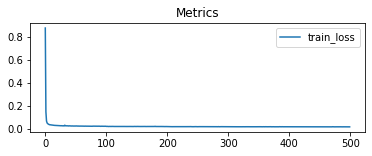

In [299]:
# Plotting the loss across the epochs:
losses.plot()

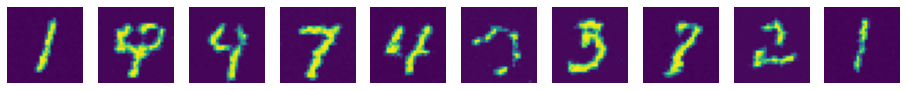

In [305]:
# Generating some images:
from ddpm import sample

imgs = sample(corruptor, model, stop_at=0)
plot_images(imgs[-1].split(1))

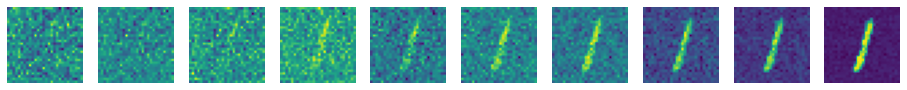

In [306]:
# Images arising from the noise:
plot_images([imgs[i][0:1,:,:] for i in range(800,len(imgs),20)])